##### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, random
from tqdm.notebook import tqdm
from matplotlib import pyplot
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import sklearn

from zipfile import ZipFile

from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.svm import SVC
import tensorflow as tf

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

import warnings; warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/Project - 2')
os.getcwd()

'D:\\Nikhila\\PGP - AIML\\2. Projects\\8. Computer Vision\\Project - 2'

# Part A

• **DOMAIN**: Entertainment

• **CONTEXT**: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved in the

• **DATA DESCRIPTION**: The dataset comprises of images and its mask for corresponding human face.

• **PROJECT OBJECTIVE**: To build a face detection system.

**Steps and tasks**:

#### 1. Import and Understand the data

##### A. Import and read ‘images.npy’.

In [3]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

data = np.load('images.npy')

In [4]:
data.shape

(409, 2)

##### Check one sample from the loaded file

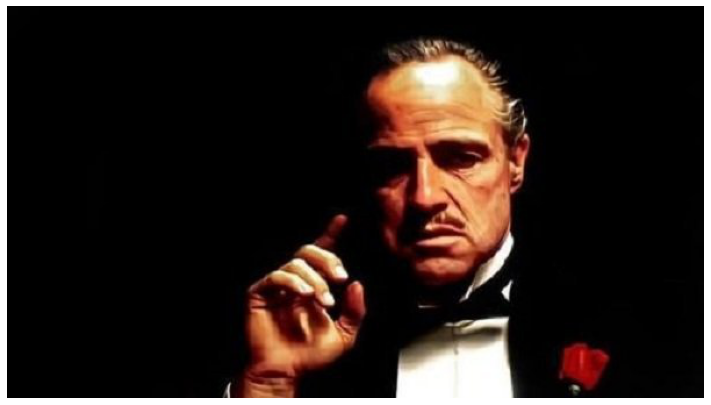

In [5]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()

##### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [6]:
data[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



**We can see that the images are stored in the form of array, each element represents the pixel value of the image.**

In [7]:
data[0][0].shape

(333, 650, 3)

**Image is of size 333 by 650 and of 3 channels i.e. RGB image.**

In [8]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

**The second column consists of information about label. It contains the size of the image (height and width), label, notes which could be the description of the image, and points which contains the x and y coordinates of faces in the image.**

#### a) Set image dimensions
* Initialize image height, image width with value: 224
* Alpha: 1

In [9]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

#### b) Create features and labels
* Here feature is the image and will be stored in "X" array
* The label is the mask and will be stored in "mask" array

In [10]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [11]:
print(X.shape)
print()
print(masks.shape)

(409, 224, 224, 3)

(409, 224, 224)


##### C. Split the data into train and test[400:9].

In [12]:
X_train = X[:400]
y_train = masks[:400]

X_valid = X[:9]
y_valid = masks[:9]

In [13]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((400, 224, 224, 3), (9, 224, 224, 3), (400, 224, 224), (9, 224, 224))

##### D. Select random image from the train data and display original image and masked image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


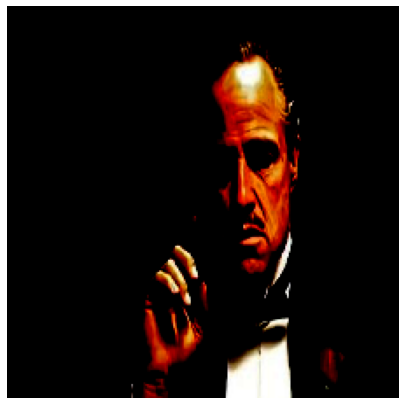

In [14]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X_train[n])

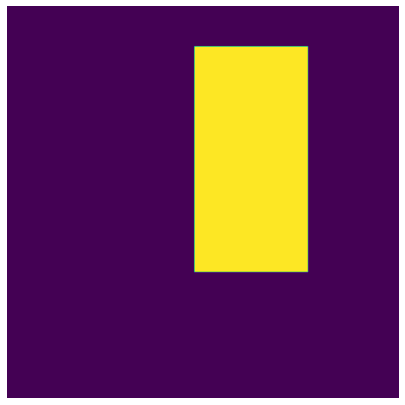

In [15]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(y_train[n])

----------------------

#### 2. Model building

##### A. Design a face mask detection model.

** Use MobileNet architecture for initial pre-trained non-trainable layers**.
- input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
- include_top: False
- alpha: 1.0
- weights: 'imagenet'


** Add appropriate Upsampling layers to imitate U-net architecture**.

In [16]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')
    
    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

In [17]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

                                                                                                  
 Conv_7_2ActivationLayer (Activ  (None, 28, 28, 256)  0          ['Conv_7_2BatchNormalization[0][0
 ation)                                                          ]']                              
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 56, 56, 256)  0          ['Conv_7_2ActivationLayer[0][0]']
                                                                                                  
 concatenate_2 (Concatenate)    (None, 56, 56, 384)  0           ['up_sampling2d_2[0][0]',        
                                                                  'conv_pw_3_relu[0][0]']         
                                                                                                  
 Conv_8_1_conv (Conv2D)         (None, 56, 56, 192)  663744      ['concatenate_2[0][0]']          
          

##### B. Design your own Dice Coefficient and Loss function.

**Dice Coefficient**

In [18]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

**Loss function**

In [19]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

##### C. Train and tune the model as required.

**Compile the model**

In [20]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

 **Define checkpoint and earlystopping**

In [21]:
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

**Fit the model**

In [22]:
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_valid, y_valid))

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 1.4865 - dice_coefficient: 0.3960
Epoch 1: loss improved from inf to 1.48645, saving model to model_1.49.h5
400/400 [==============================] - 227s 550ms/step - loss: 1.4865 - dice_coefficient: 0.3960 - val_loss: 1.3643 - val_dice_coefficient: 0.3831 - lr: 1.0000e-04
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 1.0486 - dice_coefficient: 0.5046
Epoch 2: loss improved from 1.48645 to 1.04856, saving model to model_1.05.h5
400/400 [==============================] - 226s 566ms/step - loss: 1.0486 - dice_coefficient: 0.5046 - val_loss: 1.0933 - val_dice_coefficient: 0.4478 - lr: 1.0000e-04
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.8322 - dice_coefficient: 0.5806
Epoch 3: loss improved from 1.04856 to 0.83217, saving model to model_0.83.h5
400/400 [==============================] - 222s 556ms/step - loss: 0.8322 - dice_coefficient: 0.5806 - val_loss: 1.0303 - 

Epoch 25/30
400/400 [==============================] - ETA: 0s - loss: 0.1176 - dice_coefficient: 0.9472
Epoch 25: loss improved from 0.12302 to 0.11757, saving model to model_0.12.h5
400/400 [==============================] - 222s 556ms/step - loss: 0.1176 - dice_coefficient: 0.9472 - val_loss: 0.4172 - val_dice_coefficient: 0.8167 - lr: 1.0000e-04
Epoch 26/30
400/400 [==============================] - ETA: 0s - loss: 0.1114 - dice_coefficient: 0.9505
Epoch 26: loss improved from 0.11757 to 0.11145, saving model to model_0.11.h5
400/400 [==============================] - 223s 557ms/step - loss: 0.1114 - dice_coefficient: 0.9505 - val_loss: 0.3782 - val_dice_coefficient: 0.8337 - lr: 1.0000e-04
Epoch 27/30
400/400 [==============================] - ETA: 0s - loss: 0.1039 - dice_coefficient: 0.9552
Epoch 27: loss improved from 0.11145 to 0.10391, saving model to model_0.10.h5
400/400 [==============================] - 223s 558ms/step - loss: 0.1039 - dice_coefficient: 0.9552 - val_loss:

##### D. Evaluate and share insights on performance of the model.

In [23]:
model.evaluate(X_valid, y_valid, verbose = 1)

1/1 [==============================] - 2s 2s/step - loss: 0.3655 - dice_coefficient: 0.7938


[0.36545827984809875, 0.7937591671943665]

#### Insights
Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

* Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
* Model checkpoint, early stopping and learning rate reducers were used as callbacks.
* Data was split into train and validation [400:9] ratio.
* Model weights for this were used and then used to predict on validation data to get mask.
* Further checked on sample image and imposed mask on the image.(below)
* As seen in the below images, it can be seen that model does a very good job in predicting the masks.

#### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [24]:
# Load previous model weight
WEIGHTS_FILE = "model_0.10.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_valid, verbose = 1)

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


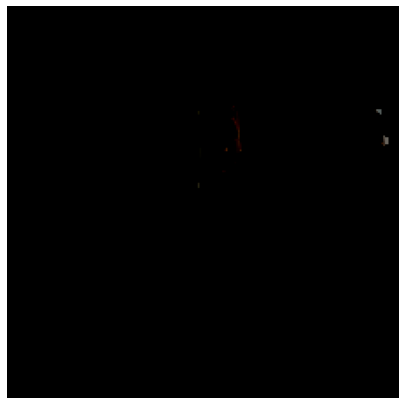

In [25]:
# image with index 3 in the test data
n = 3
image = cv2.resize(X_valid[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

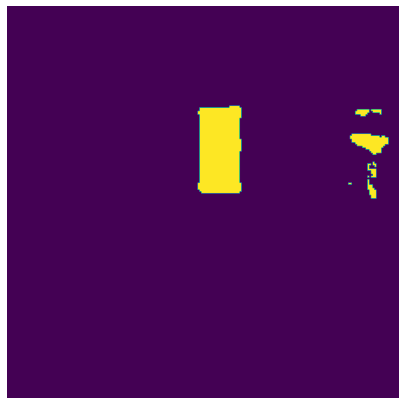

In [26]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

**Impose the mask on the image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


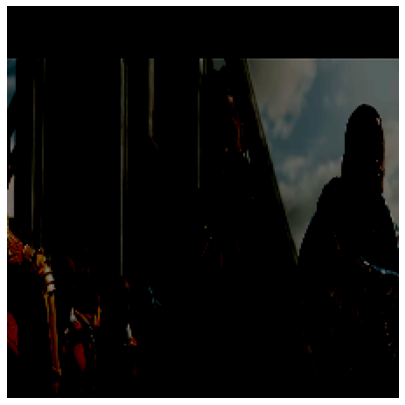

In [27]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_valid[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

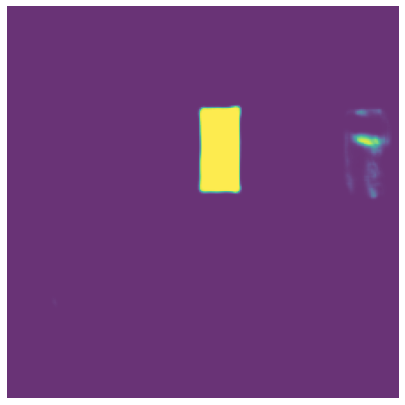

In [28]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

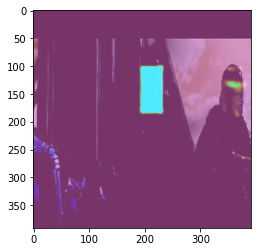

In [29]:
import cv2
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
plt.imshow(img)
plt.show()

------------

# Part B

• **DOMAIN**: Entertainment

• **CONTEXT**: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved in the

• **DATA DESCRIPTION**: The dataset comprises of face images.

• **PROJECT OBJECTIVE**: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

**Steps and tasks**:

#### 1. Read/import images from folder ‘training_images’.

In [30]:
with ZipFile('training_images-20211126T092819Z-001.zip', 'r') as zip:
  zip.extractall()

In [31]:
images = []
paths = []
folder = "D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/Project - 2/training_images"
for image_path in os.listdir(folder):
    paths.append(image_path)
    img = cv2.imread(os.path.join(folder,image_path))
    if img is not None:
        images.append(img)

#### 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

In [35]:
cascPath = "C:/Users/Nikhila KG/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

import glob
files=glob.glob("training_images/*.jpg")
for file in files:

    # Read the image
    image = cv2.imread(file)
    print(file)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(image)
    print ("Total_Faces: {0}".format(len(faces)))

    # Crop Padding
    left = 10
    right = 10
    top = 10
    bottom = 10

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        print (x, y, w, h)

        image  = image[y-top:y+h+bottom, x-left:x+w+right]

training_images\real_00001.jpg
Total_Faces: 1
146 140 428 428
training_images\real_00002.jpg
Total_Faces: 1
80 140 436 436
training_images\real_00003.jpg
Total_Faces: 1
33 121 362 362
training_images\real_00004.jpg
Total_Faces: 3
134 173 356 356
91 28 90 90
13 12 162 162
training_images\real_00005.jpg
Total_Faces: 1
344 75 110 110
training_images\real_00006.jpg
Total_Faces: 1
61 62 472 472
training_images\real_00007.jpg
Total_Faces: 1
222 213 83 83
training_images\real_00008.jpg
Total_Faces: 4
253 217 245 245
282 25 64 64
328 432 83 83
456 84 68 68
training_images\real_00009.jpg
Total_Faces: 0
training_images\real_00010.jpg
Total_Faces: 1
17 84 448 448
training_images\real_00011.jpg
Total_Faces: 1
84 120 435 435
training_images\real_00012.jpg
Total_Faces: 1
113 188 375 375
training_images\real_00013.jpg
Total_Faces: 0
training_images\real_00014.jpg
Total_Faces: 1
75 108 441 441
training_images\real_00015.jpg
Total_Faces: 1
66 92 455 455
training_images\real_00016.jpg
Total_Faces: 0
tra

training_images\real_00137.jpg
Total_Faces: 2
83 125 443 443
384 34 28 28
training_images\real_00138.jpg
Total_Faces: 1
72 109 401 401
training_images\real_00139.jpg
Total_Faces: 1
102 128 446 446
training_images\real_00140.jpg
Total_Faces: 1
94 164 399 399
training_images\real_00141.jpg
Total_Faces: 1
86 134 417 417
training_images\real_00142.jpg
Total_Faces: 1
75 110 422 422
training_images\real_00143.jpg
Total_Faces: 1
178 143 348 348
training_images\real_00144.jpg
Total_Faces: 1
75 93 450 450
training_images\real_00145.jpg
Total_Faces: 1
90 120 415 415
training_images\real_00146.jpg
Total_Faces: 0
training_images\real_00147.jpg
Total_Faces: 0
training_images\real_00148.jpg
Total_Faces: 0
training_images\real_00149.jpg
Total_Faces: 1
72 190 299 299
training_images\real_00150.jpg
Total_Faces: 1
42 87 484 484
training_images\real_00151.jpg
Total_Faces: 1
79 117 430 430
training_images\real_00152.jpg
Total_Faces: 2
71 164 381 381
220 182 339 339
training_images\real_00153.jpg
Total_Fac

Total_Faces: 1
123 179 412 412
training_images\real_00271.jpg
Total_Faces: 1
54 95 459 459
training_images\real_00272.jpg
Total_Faces: 1
27 51 477 477
training_images\real_00273.jpg
Total_Faces: 1
108 145 420 420
training_images\real_00274.jpg
Total_Faces: 1
80 156 426 426
training_images\real_00275.jpg
Total_Faces: 0
training_images\real_00276.jpg
Total_Faces: 1
87 187 337 337
training_images\real_00277.jpg
Total_Faces: 1
116 187 375 375
training_images\real_00278.jpg
Total_Faces: 1
97 191 363 363
training_images\real_00279.jpg
Total_Faces: 1
153 211 371 371
training_images\real_00280.jpg
Total_Faces: 0
training_images\real_00281.jpg
Total_Faces: 1
72 160 404 404
training_images\real_00282.jpg
Total_Faces: 0
training_images\real_00283.jpg
Total_Faces: 1
45 132 423 423
training_images\real_00284.jpg
Total_Faces: 2
28 166 409 409
505 244 55 55
training_images\real_00285.jpg
Total_Faces: 1
34 99 468 468
training_images\real_00286.jpg
Total_Faces: 1
90 197 384 384
training_images\real_002

training_images\real_00407.jpg
Total_Faces: 1
61 103 422 422
training_images\real_00408.jpg
Total_Faces: 1
66 59 467 467
training_images\real_00409.jpg
Total_Faces: 1
30 117 348 348
training_images\real_00410.jpg
Total_Faces: 1
109 70 418 418
training_images\real_00411.jpg
Total_Faces: 1
90 136 410 410
training_images\real_00412.jpg
Total_Faces: 1
114 117 398 398
training_images\real_00413.jpg
Total_Faces: 1
6 300 54 54
training_images\real_00414.jpg
Total_Faces: 1
170 248 329 329
training_images\real_00415.jpg
Total_Faces: 2
20 387 56 56
95 175 368 368
training_images\real_00416.jpg
Total_Faces: 1
93 187 348 348
training_images\real_00417.jpg
Total_Faces: 2
81 134 201 201
151 135 203 203
training_images\real_00418.jpg
Total_Faces: 1
123 135 392 392
training_images\real_00419.jpg
Total_Faces: 1
26 39 441 441
training_images\real_00420.jpg
Total_Faces: 1
18 157 349 349
training_images\real_00421.jpg
Total_Faces: 1
99 157 401 401
training_images\real_00422.jpg
Total_Faces: 1
81 62 452 45

Total_Faces: 1
56 78 473 473
training_images\real_00538.jpg
Total_Faces: 1
248 145 325 325
training_images\real_00539.jpg
Total_Faces: 1
92 84 453 453
training_images\real_00540.jpg
Total_Faces: 1
121 154 416 416
training_images\real_00541.jpg
Total_Faces: 1
59 141 398 398
training_images\real_00542.jpg
Total_Faces: 3
10 244 52 52
152 146 378 378
11 294 41 41
training_images\real_00543.jpg
Total_Faces: 2
161 515 32 32
106 271 330 329
training_images\real_00544.jpg
Total_Faces: 0
training_images\real_00545.jpg
Total_Faces: 1
67 84 451 451
training_images\real_00546.jpg
Total_Faces: 1
62 113 441 441
training_images\real_00547.jpg
Total_Faces: 1
108 170 358 358
training_images\real_00548.jpg
Total_Faces: 1
61 106 463 463
training_images\real_00549.jpg
Total_Faces: 1
78 152 422 422
training_images\real_00550.jpg
Total_Faces: 1
32 69 492 492
training_images\real_00551.jpg
Total_Faces: 1
82 135 411 411
training_images\real_00552.jpg
Total_Faces: 1
87 58 451 451
training_images\real_00553.jpg

37 33 483 483
training_images\real_00671.jpg
Total_Faces: 0
training_images\real_00672.jpg
Total_Faces: 2
323 178 149 149
485 168 102 102
training_images\real_00673.jpg
Total_Faces: 1
79 125 413 413
training_images\real_00674.jpg
Total_Faces: 3
156 366 78 78
117 229 85 85
250 184 178 178
training_images\real_00675.jpg
Total_Faces: 1
62 64 468 468
training_images\real_00676.jpg
Total_Faces: 1
115 137 419 419
training_images\real_00677.jpg
Total_Faces: 1
102 135 411 411
training_images\real_00678.jpg
Total_Faces: 1
35 98 439 439
training_images\real_00679.jpg
Total_Faces: 1
72 68 417 417
training_images\real_00680.jpg
Total_Faces: 1
72 100 466 466
training_images\real_00681.jpg
Total_Faces: 1
56 138 379 379
training_images\real_00682.jpg
Total_Faces: 1
125 193 390 390
training_images\real_00683.jpg
Total_Faces: 0
training_images\real_00684.jpg
Total_Faces: 2
278 292 89 89
267 257 78 78
training_images\real_00685.jpg
Total_Faces: 1
125 50 456 456
training_images\real_00686.jpg
Total_Faces

Total_Faces: 1
85 147 417 417
training_images\real_00807.jpg
Total_Faces: 0
training_images\real_00808.jpg
Total_Faces: 2
25 299 72 72
139 133 409 409
training_images\real_00809.jpg
Total_Faces: 1
83 99 411 411
training_images\real_00810.jpg
Total_Faces: 1
74 155 402 402
training_images\real_00811.jpg
Total_Faces: 1
87 91 446 446
training_images\real_00812.jpg
Total_Faces: 1
54 47 500 500
training_images\real_00813.jpg
Total_Faces: 1
61 82 462 462
training_images\real_00814.jpg
Total_Faces: 1
45 75 450 450
training_images\real_00815.jpg
Total_Faces: 1
16 170 407 407
training_images\real_00816.jpg
Total_Faces: 1
98 162 390 390
training_images\real_00817.jpg
Total_Faces: 1
131 193 344 344
training_images\real_00818.jpg
Total_Faces: 0
training_images\real_00819.jpg
Total_Faces: 1
60 126 414 414
training_images\real_00820.jpg
Total_Faces: 1
79 107 438 438
training_images\real_00821.jpg
Total_Faces: 1
165 140 354 354
training_images\real_00822.jpg
Total_Faces: 1
93 119 401 401
training_imag

training_images\real_00944.jpg
Total_Faces: 1
23 147 437 437
training_images\real_00945.jpg
Total_Faces: 1
54 87 466 466
training_images\real_00946.jpg
Total_Faces: 1
3 276 62 62
training_images\real_00947.jpg
Total_Faces: 1
522 138 66 66
training_images\real_00948.jpg
Total_Faces: 1
43 10 494 494
training_images\real_00949.jpg
Total_Faces: 3
41 213 50 50
354 295 60 60
510 252 58 58
training_images\real_00950.jpg
Total_Faces: 1
140 172 382 382
training_images\real_00951.jpg
Total_Faces: 0
training_images\real_00952.jpg
Total_Faces: 1
79 11 479 479
training_images\real_00953.jpg
Total_Faces: 1
294 440 65 65
training_images\real_00954.jpg
Total_Faces: 1
70 8 508 508
training_images\real_00955.jpg
Total_Faces: 1
86 152 388 388
training_images\real_00956.jpg
Total_Faces: 1
186 170 360 360
training_images\real_00957.jpg
Total_Faces: 0
training_images\real_00958.jpg
Total_Faces: 1
66 185 401 401
training_images\real_00959.jpg
Total_Faces: 1
142 113 395 395
training_images\real_00960.jpg
Tota

Total_Faces: 1
93 167 402 402
training_images\real_01078.jpg
Total_Faces: 1
65 76 468 468
training_images\real_01079.jpg
Total_Faces: 1
69 67 475 475
training_images\real_01080.jpg
Total_Faces: 1
51 87 447 447
training_images\real_01081.jpg
Total_Faces: 0


In [36]:
#Example
image = cv2.imread("training_images/real_00001.jpg")

#Initialize the face recognizer
face_cascade = cv2.CascadeClassifier("C:/Users/Nikhila KG/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml")

# detect all the faces in the image
faces = face_cascade.detectMultiScale(image)

# print the number of faces detected
print(f"{len(faces)} faces detected in the image.")

# for every face, draw a blue rectangle
for x, y, width, height in faces:
    cv2.rectangle(image, (x, y), (x + width, y + height), color=(255, 0, 0), thickness=2)

1 faces detected in the image.


In [37]:
# save the image with rectangles
cv2.imwrite("face_detected.jpg", image)

True

In [38]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

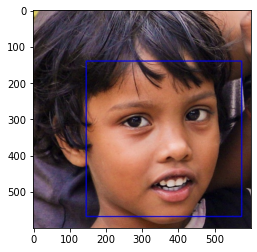

In [39]:
face_detected=load_image('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/Project - 2/face_detected.jpg')
plt.imshow(face_detected)

#### 3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [32]:
cascPath = "C:/Users/Nikhila KG/anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml"

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

boundry = {}
boundry["x"] = []
boundry["y"] = []
boundry["w"] = []
boundry["h"] = []
boundry["Total_Faces"] = []
boundry["Image_Name"] = []

for index, image in enumerate(images):
  locs = faceCascade.detectMultiScale(image)

  if len(locs) > 0:
      locs = locs[0].tolist()
      #print(locs)
      boundry["x"].append(locs[0])
      boundry["y"].append(locs[1])
      boundry["w"].append(locs[2])
      boundry["h"].append(locs[3])
      boundry["Total_Faces"].append(len(locs) // 4)
      boundry["Image_Name"].append(paths[index])

In [33]:
results = pd.DataFrame(boundry)
results

,x,y,w,h,Total_Faces,Image_Name
0,146,140,428,428,1,real_00001.jpg
1,80,140,436,436,1,real_00002.jpg
2,33,121,362,362,1,real_00003.jpg
3,91,28,90,90,1,real_00004.jpg
4,344,75,110,110,1,real_00005.jpg
...,...,...,...,...,...,...
957,66,123,432,432,1,real_01076.jpg
958,93,167,402,402,1,real_01077.jpg
959,65,76,468,468,1,real_01078.jpg
960,69,67,475,475,1,real_01079.jpg


#### 4. Save the output Dataframe in .csv format.

In [34]:
# saving the dataframe
results.to_csv('traning_images_output.csv')

--------------------------

# Part C

• **DOMAIN**: Face Recognition

• **CONTEXT**: Company X intends to build a face identification model to recognise human faces.

• **DATA DESCRIPTION**: The dataset comprises of images and its mask where there is a human face.

• **PROJECT OBJECTIVE**: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

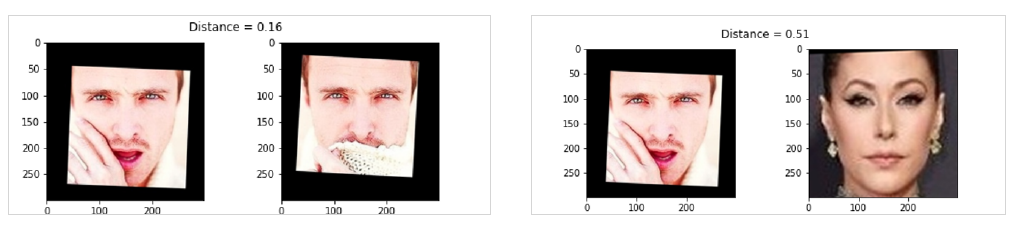

**Steps and tasks**:

In [40]:
# Set random_state
random_state = 2020

#### 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [41]:
with ZipFile('PINS.zip', 'r') as zip:
  zip.extractall()

#### 2. Write function to create metadata of the image.

In [42]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

#### 3. Write a loop to iterate through each and every image and create metadata for all the images.

In [43]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [44]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

**Load a sample image**

In [45]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

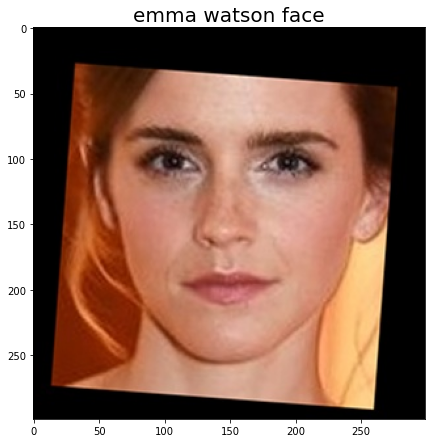

In [46]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

#### 4. Generate Embeddings vectors on the each face in the dataset.

In [47]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model
* Load the model defined above.
* Then load the given weight file named "vgg_face_weights.h5"

In [48]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

**Get vgg_face_descriptor**

In [49]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

#### Generate embeddings for each image in the dataset
Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [50]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 287ms/step
(2622,)


#### Generate embeddings for all images
Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [51]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 142ms/step


#### 5. Build distance metrics for identifying the distance between two similar and dissimilar images.

* Consider distance metric as "Squared L2 distance"
* Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [52]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs given below
* 2, 3 and 2, 180
* 30, 31 and 30, 100
* 70, 72 and 70, 115

In [53]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

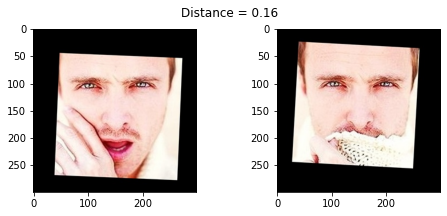

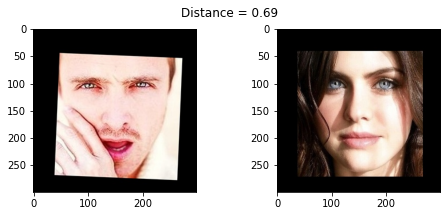

In [54]:
show_pair(2, 3)
show_pair(2, 180)

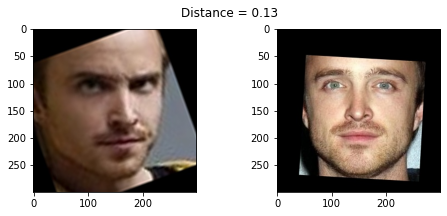

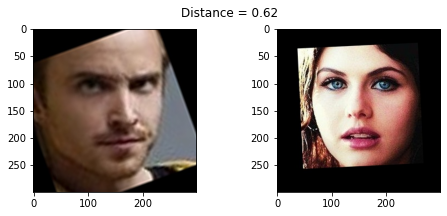

In [55]:
show_pair(30, 31)
show_pair(30, 100)

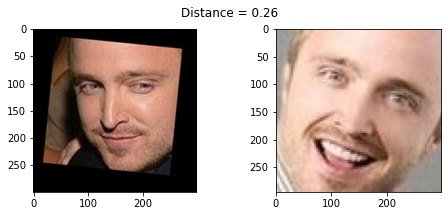

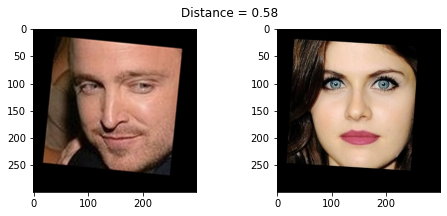

In [56]:
show_pair(70, 72)
show_pair(70, 115)

#### Create train and test sets
* Create X_train, X_test and y_train, y_test
* Use train_idx to seperate out training features and labels
* Use test_idx to seperate out testing features and labels

In [57]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

**Encode the Labels**

In [58]:
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

**Scale the features using StandardScaler**

In [59]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#### 6. Use PCA for dimensionality reduction.

In [60]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [61]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


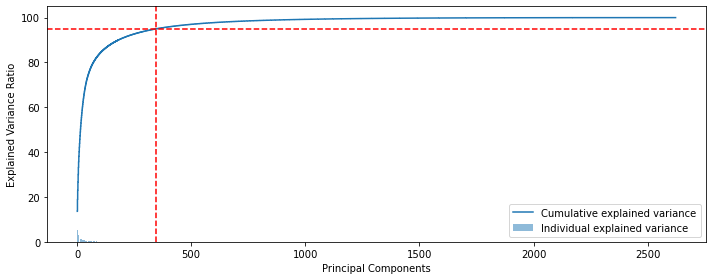

In [62]:
# Ploting 
plt.figure(figsize = (10 ,4))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [63]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

#### 7. Build an SVM classifier in order to map each image to its right person.

In [64]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [65]:
import pickle
pickle.dump(model, open('svm.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://3fea3170-fe4f-42e8-b079-dbfbe25cefaf/assets


INFO:tensorflow:Assets written to: ram://3fea3170-fe4f-42e8-b079-dbfbe25cefaf/assets


In [66]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [67]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

#### 8. Import and display the the test images.

In [68]:
Test_image_1=load_image('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/Project - 2/Dwayne Johnson4.jpg')
Test_image_2=load_image('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/Project - 2/Benedict Cumberbatch9.jpg')

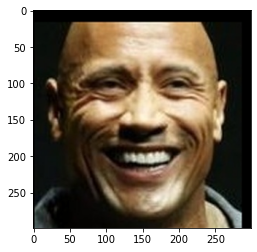

In [69]:
plt.imshow(Test_image_1)

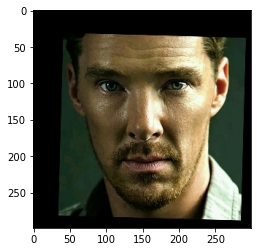

In [70]:
plt.imshow(Test_image_2)

#### 9. Use the trained SVM model to predict the face on both test images.

In [71]:
Test_image_1 = (Test_image_1 / 255.).astype(np.float32)
Test_image_1 = cv2.resize(Test_image_1, dsize = (224,224))

Test_image_2 = (Test_image_2 / 255.).astype(np.float32)
Test_image_2 = cv2.resize(Test_image_2, dsize = (224,224))

print(Test_image_1.shape)
print(Test_image_2.shape)

(224, 224, 3)
(224, 224, 3)


In [72]:
embeddings1 = np.zeros((1, 2622))
embeddings2 = np.zeros((1, 2622))

In [73]:
embedding_vector1 = vgg_face_descriptor.predict(np.expand_dims(Test_image_1, axis=0))[0]
embeddings1[0]= embedding_vector1
embedding_vector2 = vgg_face_descriptor.predict(np.expand_dims(Test_image_2, axis=0))[0]
embeddings2[0]= embedding_vector2
print(embedding_vector1.shape)
print(embedding_vector2.shape)

1/1 [==============================] - 0s 132ms/step
(2622,)
(2622,)


In [74]:
first_image = embeddings1
second_image = embeddings2

In [75]:
X_test_1 = sc.transform(first_image)
X_test_2 = sc.transform(second_image)

In [76]:
X_test_pca_1 = pca.transform(X_test_1)
X_test_pca_2 = pca.transform(X_test_2)

In [77]:
X_test_pca_1.shape
X_test_pca_2.shape

(1, 346)

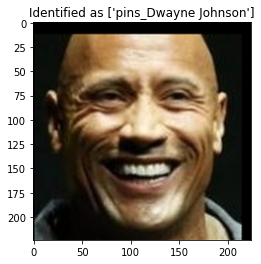

In [78]:
y_predict_1 = svc_pca.predict(X_test_pca_1)
y_predict_encoded_1 = en.inverse_transform(y_predict_1)

plt.imshow(Test_image_1)
plt.title(f'Identified as {y_predict_encoded_1}');

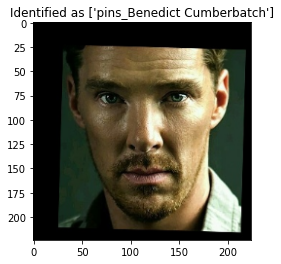

In [79]:
y_predict_2 = svc_pca.predict(X_test_pca_2)
y_predict_encoded_2 = en.inverse_transform(y_predict_2)

plt.imshow(Test_image_2)
plt.title(f'Identified as {y_predict_encoded_2}');

------------